# Support Vector Machine (SVM) and Random Forest (RF) hyperspectral data classification

In this notebook, you will train and apply two common Machine Learning classifiers - Support Vector Machine and Random Forest for classification of hyperspectral data from Luční Hora, Krkonoše mountains, Czechia.

- *Prerequisities* (This notebook can be run either online using Google Colab or on your local machine)
	- A Google account for accessing Google Colab ([link to notebook](https://colab.research.google.com/drive/17LVAThXbv9sOkGL7JCwRjzSAxumnigrs)). If running the exercise in Google Colab, please copy the notebook to your own Google Drive and follow the exercise, you don't need to download the dataset.
	
	or
	- A Python environment with the necessary libraries ([manual](../../software/software_python.md)). Download this notebook (click the download button in the top right corner of the page) and follow the exercise.

    - Downloaded data ([module4/theme4_exercise_ml_classification]())
    The dataset consists of:
        + Hyperspectral RPAS imagery of Luční Hora, Czechia (50.728N, 15.682E) acquired in August of 2020 and resampled to 54 spectral bands with ground sampling distance of 9 cm.
        + two rasters with reference data (one for training, the other for testing): BL_training_polygons.shp (shapefile)
        + Pretrained models and corresponding classified rasters: _/sample_results/*_
         
- *Tasks*
    - Preprocess imagery for Machine Learning
    - Classify the hyperspectral image using SVM or RF
	- Observe how hyperparameter values alter classification results
	- Evaluate your results and compare to our pretrained classifiers
    - *Optional:* Classify a urban scene

## Structure of this exercise

What are you going to encounter during this exercise.

0. Load libraries, set paths
1. Load and Preprocess training data
2. Create/Fit Classifiers  
    2A Create/Fit Support Vector Machine  
    2B Create/Fit Random Forest
3. Apply Classifier
4. Evaluate Result
5. Sample Solutions  
    5A SVM  
    5B RF

## 0. Load external libraries and set paths

First, we need to import external libraries:

- __numpy__ - Arrays to hold our data
- __matplotlib.pyplot__ - Draw images

- __sklearn.svm / sklearn.ensemble__ - Machine Learning Classifiers
- __sklearn.model_selection__ - Cross-validation and hyperparameter tuning implemented in scikit-learn
- __sklearn.metrics__ - Compute accuracy metrics using scikit-learn
- __sklearn.preprocessing__ - Normalizing input data using scikit-learn

- __time.perf_counter__ - Track how long individual functions take to run
- __os.path__ - Path manipulation
- __tqdm__ - show progress bars during training
- __joblib__ - Saving and loading trained classifiers

- __image_preprocessing__ - Our library holding functions for image tiling, preprocessing, etc.
- __inference_utils__ - Our library for correctly exporting classifed images
- __visualisation_utils__ - Our library for visualising the data

Two external libraries are not imported directly in this notebook, but are used by functions in _image_preprocessing_ and _inference_utils_:

- __gdal__ - Manipulates spatial data
- __scipy.io__ - Reads .mat files

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter
from os.path import join
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report

from tqdm import notebook as tqdm
from joblib import dump, load

import image_preprocessing
import inference_utils
import visualisation_utils

# GLOBAL SETTINGS
plt.rcParams['figure.figsize'] = [5, 5]
np.set_printoptions(precision=2, suppress=True)  # Array print precision

In [2]:
# Set dataset name (used by visualisation functions) - 'krknonose' or 'pavia_centre'
# default: 'pavia_centre'
ds_name = 'krkonose'

# Get a list of class names
_, class_names = visualisation_utils._create_colorlist_classnames(ds_name=ds_name)

Please fill correct paths to your training and reference rasters (just pointing the _root_path_ variable to the project folder should do):

In [3]:
root_path = 'f:/datasets/etrainee'
# root_path = 'C:/folder/where/this/project/is/saved'

# PATHS TO TRAINING DATA
# Krkonose
imagery_path = join(root_path, 'LH_202008_imagery.tif')
reference_path   = join(root_path, 'LH_202008_reference.tif')
# Pavia
#imagery_path = join(root_path, 'Pavia.mat')
#train_path   = join(root_path, 'Pavia_gt.mat')
#test_path    = join(root_path, 'Pavia_gt.mat')

# PATH TO SAVE MODELS
model_save_folder = join(root_path, 'models')

# PATH TO SAVE CLASSIFIED IMAGE
out_path_svm = join(root_path, 'results/Krkonose_SVM.tif')

# PATH TO THE SAMPLE RESULTS
sample_result_path_svm = join(root_path, 'sample_results/SVM_sample_result.tif')
sample_result_path_rf  = join(root_path, 'sample_results/RF_sample_result.tif')

## 1. Load and preprocess training data

### 1.1. Data loading into NumPy
Let's start by reading an image into a numpy array, we do this in the background using GDAL.

The result of our function is a dictionary named loaded_raster, which contains two numpy arrays under keys _imagery_ and _reference_. As we can see, the loaded hyperspectral dataset has 1088 by 1088 pixels with 54 spectral bands. The raster containing our reference data has the same dimensions in height and width.

For loading most raster datasets, we created a _read_gdal()_ function in the _image_preprocessing_ module. But loading .mat files for the Pavia City Centre requires a specific function (_read_pavia_centre()_). Both _read_pavia_centre()_ and _read_gdal()_ return a dictionary containing two numpy arrays with keys _imagery_ and _reference_.

If using the Pavia City Centre dataset, you may notice that the original image has a shape of (1096, 1096, 102), but to make the data easier to tile for neural networks, we crop the image to (1088, 1088, 102) here.

In [4]:
loaded_raster = image_preprocessing.read_gdal(imagery_path, reference_path)
#loaded_raster = image_preprocessing.read_pavia_centre(imagery_path,
    # train_path, out_shape=(1088, 1088, 102))

print(f'Tiled imagery shape {loaded_raster["imagery"].shape}')
print(f'Tiled reference shape {loaded_raster["reference"].shape}')

C:\Users\dd\.conda\envs\etrainee_m4\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Tiled imagery shape (1088, 1088, 54)
Tiled reference shape (1088, 1088, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


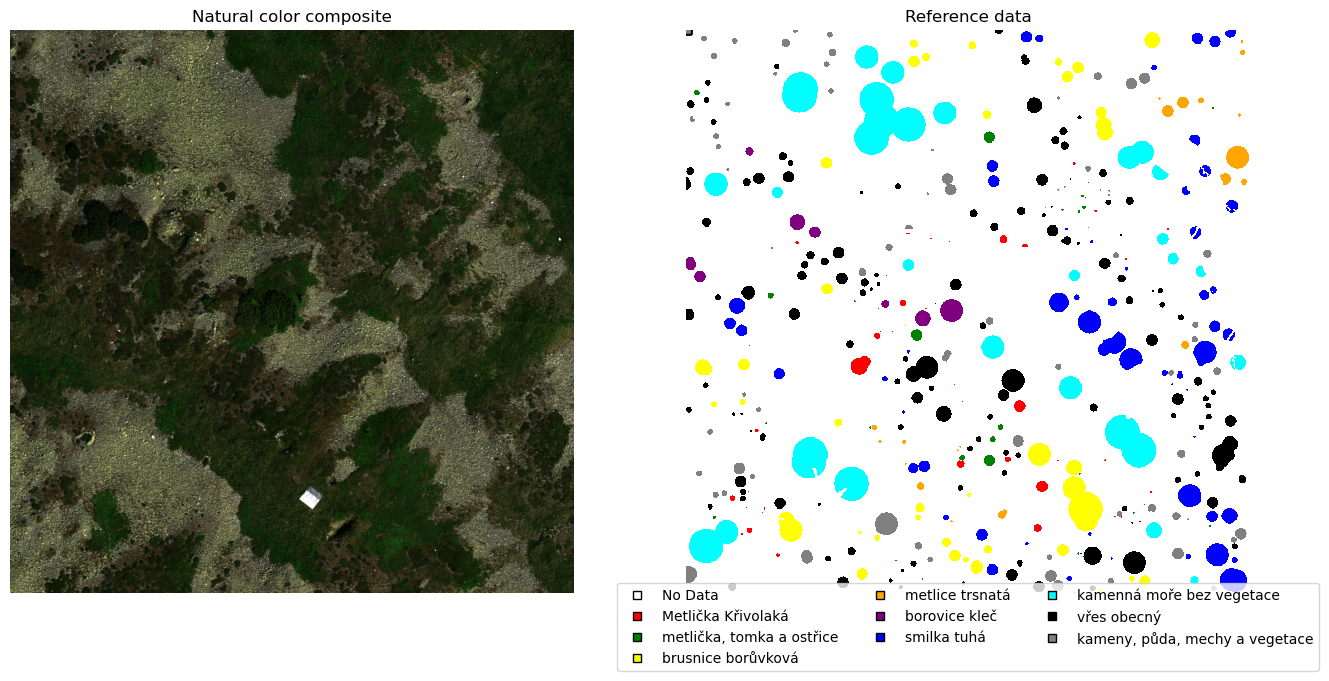

In [5]:
visualisation_utils.show_img_ref(loaded_raster["imagery"][:, :, [25, 15, 5]],
                                 loaded_raster["reference"], ds_name=ds_name)

### 1.2. Flatten array
We will be using SVM and RF to classify individual pixels, therefore we can transform the 3D image (height, width, spectral bands) to a 2D array (length, spectral bands). This transformation destroys spatial relationships within the image, however the classifiers can only use 1D features anyway and it simplifies the next step (filtering NoData).

In [6]:
orig_shape = loaded_raster['imagery'].shape

flat_arrs = {}
flat_arrs['imagery'] = loaded_raster['imagery'].reshape(
    orig_shape[0]*orig_shape[1], orig_shape[2])
flat_arrs['reference'] = loaded_raster['reference'].reshape(
    orig_shape[0]*orig_shape[1])

print(f'The flat imagery array has shape {flat_arrs["imagery"].shape}')

The flat imagery array has shape (1183744, 54)


### 1.3. Filter out NoData pixels

We can only train the classifier on pixels with a reference value, therefore we remove all pixels belonging to class 0 (NoData). This operation reduces our training dataset from ~1.23 milion to ~50 thousand pixels. We then visualise the spectral curves of individual pixels.

In [7]:
filtered_arrs = {}
filtered_arrs['imagery'] = flat_arrs['imagery'][flat_arrs['reference'] > 0]
filtered_arrs['reference'] = flat_arrs['reference'][flat_arrs['reference'] > 0]

print(f'The filtered array has shape {filtered_arrs["imagery"].shape}')

The filtered array has shape (148486, 54)


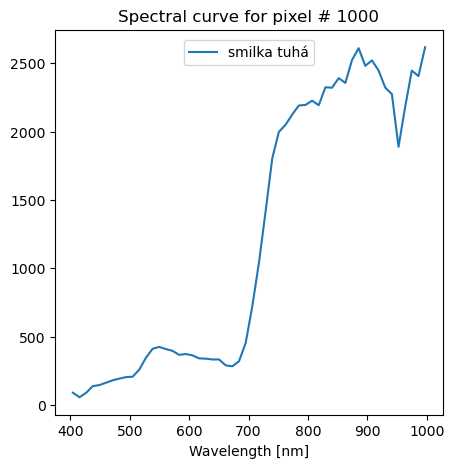

In [8]:
pixel_number = 1000
visualisation_utils.show_spectral_curve(filtered_arrs, pixel_number,
                                        ds_name=ds_name)

### 1.4. Subsetting the training data
With the whole training dataset, the training procedure may take relatively long. Instead we randomly select a number of samples from each class for training.

In [9]:
split = train_test_split(filtered_arrs['imagery'], filtered_arrs['reference'], train_size=1/3)
train = np.unique(split[2], return_counts=True)[1] / split[2].shape[0]
test  = np.unique(split[3], return_counts=True)[1] / split[3].shape[0]
print(train)
print(test)

X_train, X_test, y_train, y_test = split

[0.02 0.01 0.13 0.03 0.03 0.16 0.34 0.2  0.08]
[0.02 0.01 0.13 0.03 0.03 0.16 0.35 0.19 0.08]


In [ ]:
X_train.shape

In [10]:
# How many training samples do we have for each class?
unique, counts = np.unique(y_train, return_counts=True)
print(f'The individual classes contain {counts} training pixels.')

The individual classes contain [ 1071   635  6395  1310  1477  7765 17017  9791  4034] training pixels.


In [ ]:
# How many samples per class do we pick?
n_class_samples = 600

In [ ]:
# Create an array for random indices
indices_random = np.zeros((n_class_samples*len(unique)), dtype=np.uint32)
sorted_reference = np.argsort(filtered_arrs['reference'])

# Randomly select the same number of indices from each class
start = 0
for idx in range(len(counts)):
    indices_random[(idx*n_class_samples):((idx+1)*n_class_samples)] = np.random.choice(
        sorted_reference[start:(start+counts[idx])], size=n_class_samples, replace=False)
    start += counts[idx]

In [ ]:
# Subset the original arrays using the random indices
subset_arrs = {}
subset_arrs['imagery'] = filtered_arrs['imagery'][indices_random, :]
subset_arrs['reference'] = filtered_arrs['reference'][indices_random]

In [ ]:
# Let's check how many pixels are in each class now
unique, counts = np.unique(subset_arrs['reference'], return_counts=True)
print(f'Now, the individual classes contain {counts} training pixels.')

Let's visualise some of the pixels

In [ ]:
pixel_number = 300
visualisation_utils.show_spectral_curve(subset_arrs, pixel_number,
                                        ds_name=ds_name)

### 1.5. Data scaling
After filtering the training data, we can move onto data scaling. In Machine Learning, it is common to scale all features before classification, because many classifiers assume that all features vary on comparable scales  and that each feature has values close to zero.

In [ ]:
preprocessed_arrs['imagery'] = X_train
preprocessed_arrs['reference'] = y_train

In [11]:
preprocessed_arrs = {}
scaler = StandardScaler()
scaler.fit(flat_arrs['imagery'])
preprocessed_arrs['imagery'] = scaler.transform(X_train)
preprocessed_arrs['reference'] = y_train

X_test = scaler.transform(X_test)

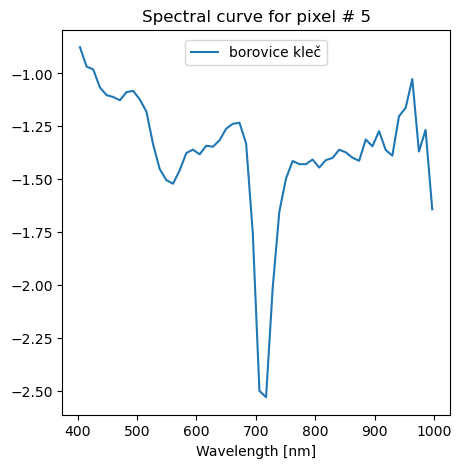

In [12]:
pixel_number = 5
visualisation_utils.show_spectral_curve(preprocessed_arrs, pixel_number,
                                        ds_name=ds_name)

### SAM

In [ ]:
# training data into spectral library
preprocessed_arrs['imagery'][:, None].shape
#preprocessed_arrs['reference']

In [ ]:
np.unique(preprocessed_arrs['reference'], return_inverse=True)

In [ ]:
preprocessed_arrs['imagery'][preprocessed_arrs['reference'] == 1]

In [13]:
num_classes = np.unique(preprocessed_arrs['reference']).shape[0]
num_bands   = preprocessed_arrs['imagery'].shape[1]
mean_bands = np.empty((num_classes, num_bands))

for class_val in np.unique(preprocessed_arrs['reference']):
    mean_bands[class_val-1, :] = np.mean(preprocessed_arrs['imagery'][preprocessed_arrs['reference'] == class_val], axis=0)

spectral_lib = {'imagery': mean_bands, 'reference': np.unique(preprocessed_arrs['reference'])}

In [14]:
from pysptools.classification import SAM, SID

In [ ]:
visualisation_utils.show_spectral_curve(spectral_lib, 0,
                                        ds_name=ds_name)

In [15]:
mean_bands

array([[-0.55, -0.53, -0.53, -0.53, -0.53, -0.53, -0.53, -0.53, -0.53,
        -0.52, -0.51, -0.48, -0.46, -0.45, -0.44, -0.44, -0.43, -0.42,
        -0.4 , -0.38, -0.36, -0.34, -0.35, -0.34, -0.34, -0.3 , -0.11,
         0.3 ,  0.64,  0.7 ,  0.67,  0.63,  0.63,  0.64,  0.64,  0.65,
         0.65,  0.66,  0.67,  0.67,  0.67,  0.68,  0.68,  0.68,  0.67,
         0.68,  0.69,  0.65,  0.68,  0.69,  0.72,  0.73,  0.73,  0.71],
       [-0.71, -0.67, -0.64, -0.63, -0.64, -0.64, -0.64, -0.64, -0.63,
        -0.63, -0.61, -0.58, -0.54, -0.52, -0.52, -0.54, -0.55, -0.54,
        -0.54, -0.53, -0.52, -0.51, -0.52, -0.52, -0.52, -0.49, -0.33,
         0.12,  0.61,  0.81,  0.84,  0.84,  0.84,  0.85,  0.86,  0.87,
         0.88,  0.88,  0.89,  0.9 ,  0.9 ,  0.9 ,  0.91,  0.91,  0.91,
         0.91,  0.91,  0.92,  0.92,  0.92,  0.94,  0.93,  0.92,  0.92],
       [-0.71, -0.72, -0.74, -0.77, -0.79, -0.79, -0.78, -0.78, -0.77,
        -0.74, -0.67, -0.54, -0.43, -0.37, -0.39, -0.47, -0.55, -0.58,
    

In [ ]:
sam = SAM()

In [ ]:
classified = sam.classify(preprocessed_arrs['imagery'][:, None], mean_bands)

In [ ]:
classified[:,0].shape

## 2A. Support Vector Machine definition and training

After preprocessing our data, we can move onto defining our machine learning models. You can either train your own classifiers or use ones we already trained for you (_sample_results/SVM_sample_trained.joblib_). In case you are using the pretrained SVM, skip ahead to section 2A.3.

This training uses a support vector machine implementation from scikit-learn, a popular Machine Learning library for Python. The documentation is available at [https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

### 2A.1. Find most suitable parameters

To function proprely, SVM has to have suitable values for some hyperparameters. A common approach is to try different values for the hyperparameters, for example kernel, degree, C and gamma.

Scikit-Learn makes this easy using RandomizedSearch or GridSearch, these functions train the classifier multiple times using different hyperparameter values and determine the most suitable combination. Each combination of hyperparameter values is tried multiple times using cross-validation (out-of-sample testing).

Run either the cell with RandomizedSearchCV or with GridSearchCV, while Grid Search may be able to find mor suitable hyperparameters, Randomized Search will likely also find suitable solutions in a much shorter amount of time.

In [ ]:
# define potential hyperparameter values for the SVM (values to try)
parameters_svm = {
    'kernel': ['poly', 'rbf'],               # Define the kernel function
    'degree': [2, 3],                        # Degree of polynomial used for the 'poly' kernel
    'C': [0.1, 1, 10, 100, 1000, 10000],     # Define the penalty value
    'gamma': [.00001, .0001, .001, .01, .1], # Kernel parameter
}

In [ ]:
# Create the optimizer and run the optimization
opt = RandomizedSearchCV(SVC(), parameters_svm, cv=5, 
                         scoring="jaccard_micro", n_iter=8, refit=False,
                         verbose=4, n_jobs=-2)
opt.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
print(f'The optimisation process identified these parameters as the most suitable: {opt.best_params_}')

In [ ]:
# Create the optimizer and run the optimization
opt = GridSearchCV(SVC(), parameters_svm, cv=5, scoring="jaccard_micro", refit=False, verbose=4, n_jobs=-2)
opt.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
print(f'The optimisation process identified these parameters as the most suitable: {opt.best_params_}')

### 2A.2. Fit
The best hyperparameter values identified during cross-validation are then used for training the model on the whole training dataset.

In [ ]:
svm = SVC(**opt.best_params_)

svm.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])

### 2A.3. Save/load trained SVM for potential future use

In [ ]:
# save using joblib.dump(object, filename)
model_path = join(model_save_folder, 'SVM.joblib')
dump(svm, model_path)

In [ ]:
# load using joblib.load(filename)
model_path = join(model_save_folder, 'SVM.joblib')
svm = load(model_path)

## 2B. Random Forest definition and training

After preprocessing our data, we can move onto defining our machine learning models. You can either train your own classifiers or use ones we already trained for you (_sample_results/RF_sample_trained.joblib_). In case you are using the pretrained RF, skip ahead to section 2B.3.

This training uses a Random Forest implementation from scikit-learn, a popular Machine Learning library for Python. The documentation is available at [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### 2B.1. Find most suitable parameters

To function proprely, SVM has to have suitable values for some hyperparameters. A common approach is to try different values for the hyperparameters, for example kernel, degree, C and gamma.

Scikit-Learn makes this easy using RandomizedSearch or GridSearch, these functions train the classifier multiple times using different hyperparameter values and determine the most suitable combination. Each combination of hyperparameter values is tried multiple times using cross-validation (out-of-sample testing).

Run either the cell with RandomizedSearchCV or with GridSearchCV, while Grid Search may be able to find mor suitable hyperparameters, Randomized Search will likely also find suitable solutions in a much shorter amount of time.

In [ ]:
# define potential parameter values for the SVM
parameters_rf = {
    'n_estimators': [50, 100, 250, 500, 750], # Number of trees in the forest
    'max_depth': [3, 5, 10, 20, 50],          # Maximum depth of a tree
}

In [ ]:
# Create the optimizer and run the optimization
opt = RandomizedSearchCV(RandomForestClassifier(), parameters_rf, cv=5, scoring="jaccard_macro", n_iter=8, refit=False, n_jobs=-2, verbose=4)
opt.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
print(f'The optimisation process identified these parameters as the most suitable: {opt.best_params_}')

In [ ]:
# Create the optimizer and run the GridSerach optimization
opt = GridSearchCV(RandomForestClassifier(), parameters_rf, cv=5, scoring="jaccard_micro", refit=False, n_jobs=-2, verbose=4)
opt.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
print(f'The optimisation process identified these parameters as the most suitable: {opt.best_params_}')

### 2B.2. Fit
The best hyperparameter values identified during cross-validation are then used for training the model on the whole training dataset.

In [ ]:
rf = RandomForestClassifier(**opt.best_params_)

rf.fit(X=preprocessed_arrs['imagery'], y=preprocessed_arrs['reference'])
rf.score(preprocessed_arrs['imagery'], preprocessed_arrs['reference'])

### 2B.3. Save/load trained RF for potential future use

In [ ]:
# save using joblib.dump(object, filename)
model_path = join(model_save_folder, 'RF.joblib')
dump(rf, model_path)

In [ ]:
# load using joblib.load(filename)
rf = load(model_path)

## 3. Model application & evaluation

### 3.1. Loading and preprocessing the data

Load a raster to classify. This can be the one that we used for training, but it can also be a different raster with the same number of bands.

By default, the training raster (_imagery_path_) is used.

In [17]:
# Load raster
raster = image_preprocessing.read_gdal_with_geoinfo(imagery_path, (0,0))

# Flattern spatial dimension of the raster
raster_shape = raster['imagery'].shape
raster_flat = raster['imagery'].reshape(raster_shape[0]*raster_shape[1],
                                        raster_shape[2])

# Preprocess(scale) the data
scaler = StandardScaler()
scaler.fit(raster_flat)
raster_scaled = scaler.transform(raster_flat)
#raster_scaled = raster_flat

### 3.2. Applying the classifier

The following snippet applies the classifier to the loaded imagery, and then transforms the flattened array back into a raster.

In [ ]:
# Select if you want to apply the SVM or RF
#model = svm
model = rf

In [18]:
sam = SAM()
predicted_flat = sam.classify(raster_scaled[:, None], mean_bands, threshold=0.5)[:, 0]

In [ ]:
sid = SID()
predicted_flat = sid.classify(raster_scaled[:, None], mean_bands, threshold=0.5)[:, 0]

In [ ]:
np.unique(predicted_flat, return_counts=True)

In [19]:
predicted_raster = predicted_flat.reshape(raster_shape[0], raster_shape[1])

You can also visualise the result:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


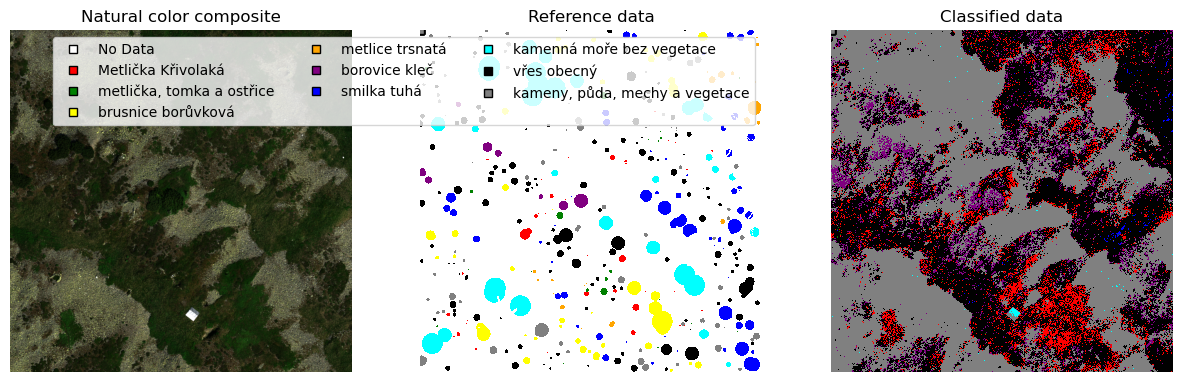

In [20]:
visualisation_utils.show_classified(loaded_raster['imagery'][:, :, [25, 15, 5]],
                                    loaded_raster['reference'],
                                    predicted_raster, ds_name=ds_name)

In [ ]:
from sklearn import pipeline

### 3.3. Export resulting raster

Export the resulting classified raster into _out_path_ for distribution or further analysis (e.g. validation in GIS).

In [ ]:
#Choose if saving the SVM or RF result
#out_path = out_path_svm
out_path = out_path_rf

inference_utils.export_result(out_path, predicted_raster, raster['geoinfo'])

## 4. Evaluate Classification Result

### 4.1. Load Test Raster

The test raster is loaded using the same functions as before.

In [ ]:
# Read raster
test_arr = image_preprocessing.read_gdal(imagery_path, test_path)
test_flat = test_arr['reference'].reshape(
    test_arr['reference'].shape[0]*test_arr['reference'].shape[1])
test_filtered = test_flat[test_flat > 0]

In [ ]:
predicted_filtered = predicted_flat[test_flat > 0]
test_filtered = test_flat[test_flat > 0]

### 4.2. Compute accuracy metrics

In [21]:
sam = SAM()
classified_test = sam.classify(X_test[:, None], mean_bands, threshold=0.5)[:, 0]

In [ ]:
sid = SID()
classified_test = sid.classify(X_test[:, None], mean_bands, threshold=0.5)[:, 0]

In [ ]:
X_test

In [ ]:
np.unique(classified_test, return_counts=True)

In [ ]:
np.unique(y_test, return_counts=True)

In [23]:
print(classification_report(y_test, classified_test,
      target_names=class_names[0:]))

                                precision    recall  f1-score   support

                       No Data       0.00      0.00      0.00         0
            Metlička Křivolaká       0.11      0.38      0.17      2183
     metlička, tomka a ostřice       0.05      0.01      0.01      1266
            brusnice borůvková       0.00      0.00      0.00     12917
               metlice trsnatá       0.00      0.00      0.00      2539
                 borovice kleč       0.25      0.62      0.36      3108
                   smilka tuhá       0.43      0.01      0.02     15523
     kamenná moře bez vegetace       1.00      0.00      0.01     34152
                   vřes obecný       0.30      0.58      0.40     19286
kameny, půda, mechy a vegetace       0.15      0.84      0.25      8017

                      accuracy                           0.21     98991
                     macro avg       0.23      0.24      0.12     98991
                  weighted avg       0.49      0.21      0.12 

C:\Users\dd\.conda\envs\etrainee_m4\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dd\.conda\envs\etrainee_m4\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dd\.conda\envs\etrainee_m4\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dd\.conda\envs\etrain

### 4.3. Show Confusion Matrix

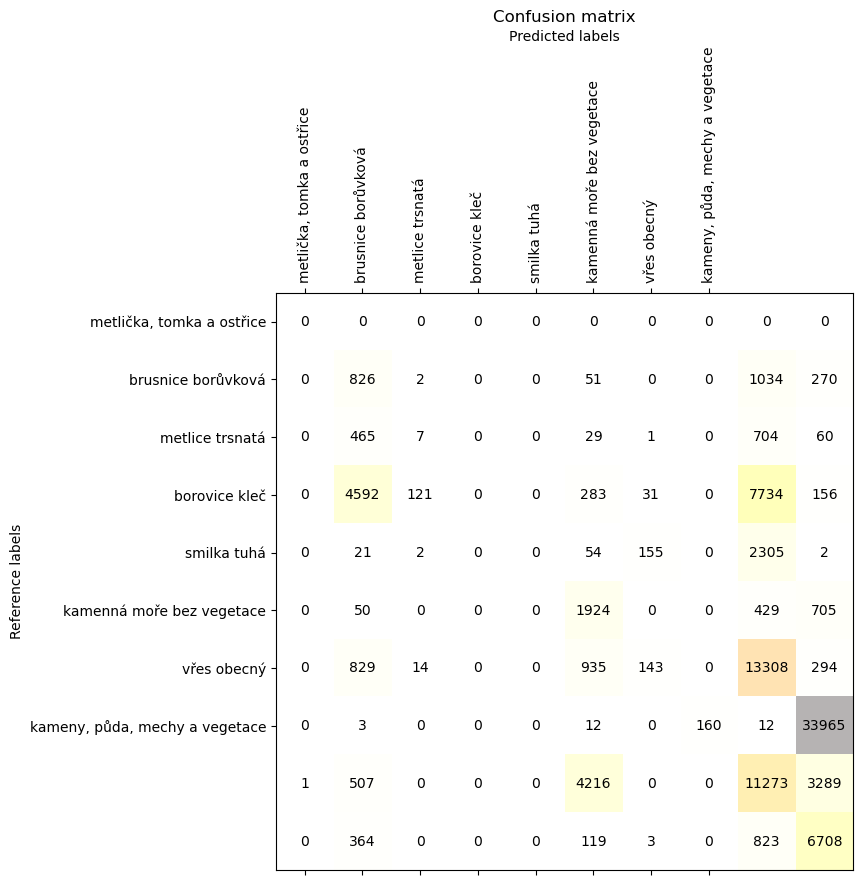

In [24]:
visualisation_utils.show_confusion_matrix(y_test, classified_test,
                                          ds_name=ds_name)

## 5A. Sample Solution (SVM)

We have generated this result using these training parameters (please note that just using the same training parameters will not yield the same result):

- Kernel: Polynomial
- Polynom degree: 2
- C: 1000
- Gamma: 0.01

In [ ]:
# Read test reference
test_arr = image_preprocessing.read_gdal(imagery_path, test_path)
test_flat = test_arr['reference'].reshape(
    test_arr['reference'].shape[0]*test_arr['reference'].shape[1])
test_filtered = test_flat[test_flat > 0]

# Read sample result
sample_arr = image_preprocessing.read_gdal(imagery_path, sample_result_path_svm)
sample_flat = sample_arr['reference'].reshape(
    sample_arr['reference'].shape[0] * sample_arr['reference'].shape[1])
sample_filtered = sample_flat[test_flat > 0]

In [ ]:
# Visualise the sample result
visualisation_utils.show_classified(loaded_raster['imagery'][:, :, [25, 15, 5]],
                                    loaded_raster['reference'],
                                    sample_arr['reference'],
                                    ds_name=ds_name)

In [ ]:
# Print a classification report for the sample result
print(classification_report(test_filtered, sample_filtered,
      target_names=class_names[1:]))

In [ ]:
# Show a Confusion matrix for the sample result
visualisation_utils.show_confusion_matrix(test_filtered, sample_filtered,
                                          ds_name=ds_name)

## 5B. Sample Solution (RF)

We have generated this result using these training parameters (please note that just using the same training parameters will not yield the same result):

- Number of trees: 750
- Maximium tree depth: 50

In [ ]:
# Read test reference
test_arr = image_preprocessing.read_gdal(imagery_path, test_path)
test_flat = test_arr['reference'].reshape(
    test_arr['reference'].shape[0]*test_arr['reference'].shape[1])
test_filtered = test_flat[test_flat > 0]

# Read sample result
sample_arr = image_preprocessing.read_gdal(imagery_path, sample_result_path_rf)
sample_flat = sample_arr['reference'].reshape(
    sample_arr['reference'].shape[0] * sample_arr['reference'].shape[1])
sample_filtered = sample_flat[test_flat > 0]

In [ ]:
# Visualise the sample result
visualisation_utils.show_classified(loaded_raster['imagery'][:, :, [25, 15, 5]],
                                    loaded_raster['reference'],
                                    sample_arr['reference'],
                                    ds_name=ds_name)

In [ ]:
# Print a classification report for the sample result
print(classification_report(test_filtered, sample_filtered,
      target_names=class_names[1:]))

In [ ]:
# Show a Confusion matrix for the sample result
visualisation_utils.show_confusion_matrix(test_filtered, sample_filtered,
                                          ds_name=ds_name)

## *Optional:* Classify a urban scene

Try using this notebook to classify a urban scene (Pavia City Centre). Reflect on how the different landscape structure and clearer class definitions influence the classification result.

Pavia city centre is a common benchmark for hyperspectral data classification and can be obtained from [http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Pavia_Centre_and_University](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Pavia_Centre_and_University). You will need to change the paths to input data and use the *read_pavia_centre* method to load the matlab matrices into numpy.